In [1]:
import sys

!{sys.executable} -m pip install sagemaker pandas numpy --upgrade
!pip3 install -U sagemaker

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [1]:
bucket = 'churn-saa'
prefix = 'sagemaker/final-sonar'


In [2]:
# Define IAM role
import boto3
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sagemaker
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer

In [3]:
train_data= pd.read_csv('X_train.csv',header=None)

In [4]:
validation_data = pd.read_csv('X_val.csv',header=None)

In [26]:
test_data = pd.read_csv('X_test.csv',header=None)

In [6]:
validation_data.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1,802,2,1,60,3,92887.06,1,1,0,39473.63
1,1,602,2,1,56,3,115895.22,3,1,0,4176.17
2,0,801,2,1,32,4,75170.54,1,1,1,37898.50
3,0,693,3,1,34,10,107556.06,2,0,0,154631.35
4,0,592,2,1,62,5,0.00,1,1,1,100941.57


In [7]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('X_train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('X_val.csv')
s3_input_train = TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [8]:
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'}

sess = sagemaker.Session()

In [9]:
role = get_execution_role()
xgb = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

In [10]:
xgb.set_hyperparameters(eval_metric="auc", eta=0.1, objective='binary:logistic', num_round=100) 
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

INFO:sagemaker:Creating training-job with name: xgboost-2023-04-14-07-58-10-532


2023-04-14 07:58:10 Starting - Starting the training job...
2023-04-14 07:58:37 Starting - Preparing the instances for training......
2023-04-14 07:59:42 Downloading - Downloading input data...
2023-04-14 08:00:12 Training - Downloading the training image......
2023-04-14 08:01:03 Uploading - Uploading generated training modelArguments: train
[2023-04-14:08:00:58:INFO] Running standalone xgboost training.
[2023-04-14:08:00:58:INFO] File size need to be processed in the node: 0.34mb. Available memory size in the node: 8600.28mb
[2023-04-14:08:00:58:INFO] Determined delimiter of CSV input is ','
[08:00:58] S3DistributionType set as FullyReplicated
[08:00:58] 6499x10 matrix with 64990 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2023-04-14:08:00:58:INFO] Determined delimiter of CSV input is ','
[08:00:58] S3DistributionType set as FullyReplicated
[08:00:58] 2999x10 matrix with 29990 entries loaded from /opt/ml/input/data/validation?format=csv&label_c

In [11]:
xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge', serializer = CSVSerializer())

INFO:sagemaker:Creating model with name: xgboost-2023-04-14-08-01-56-696
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-04-14-08-01-56-696
INFO:sagemaker:Creating endpoint with name xgboost-2023-04-14-08-01-56-696


-----------!

### Model Creation

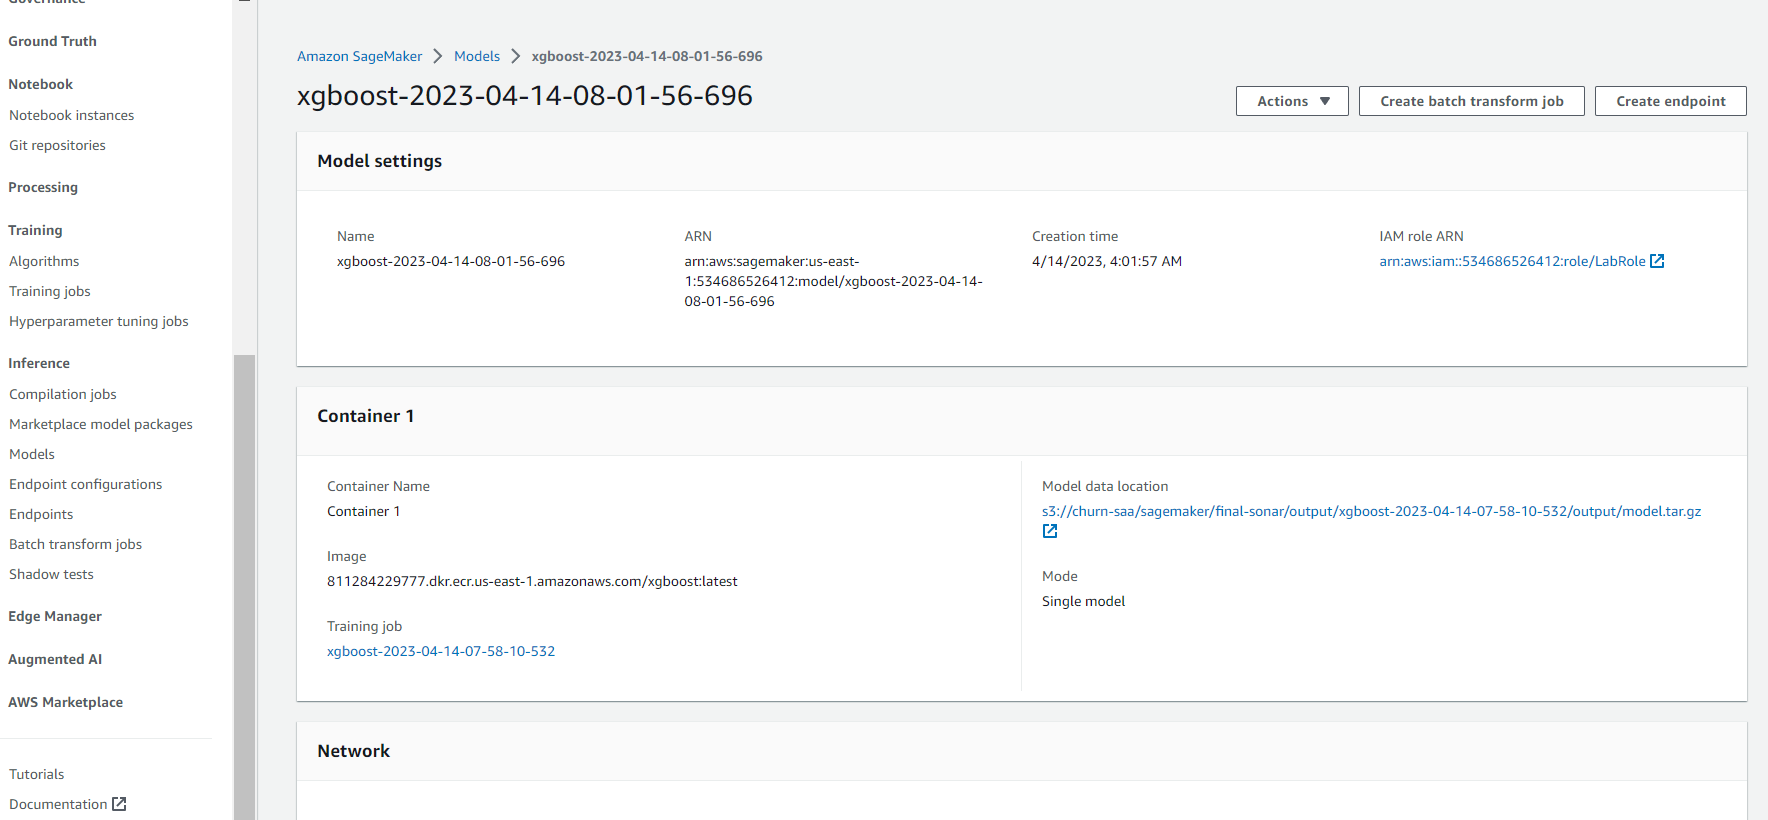

### Endpoint Creation

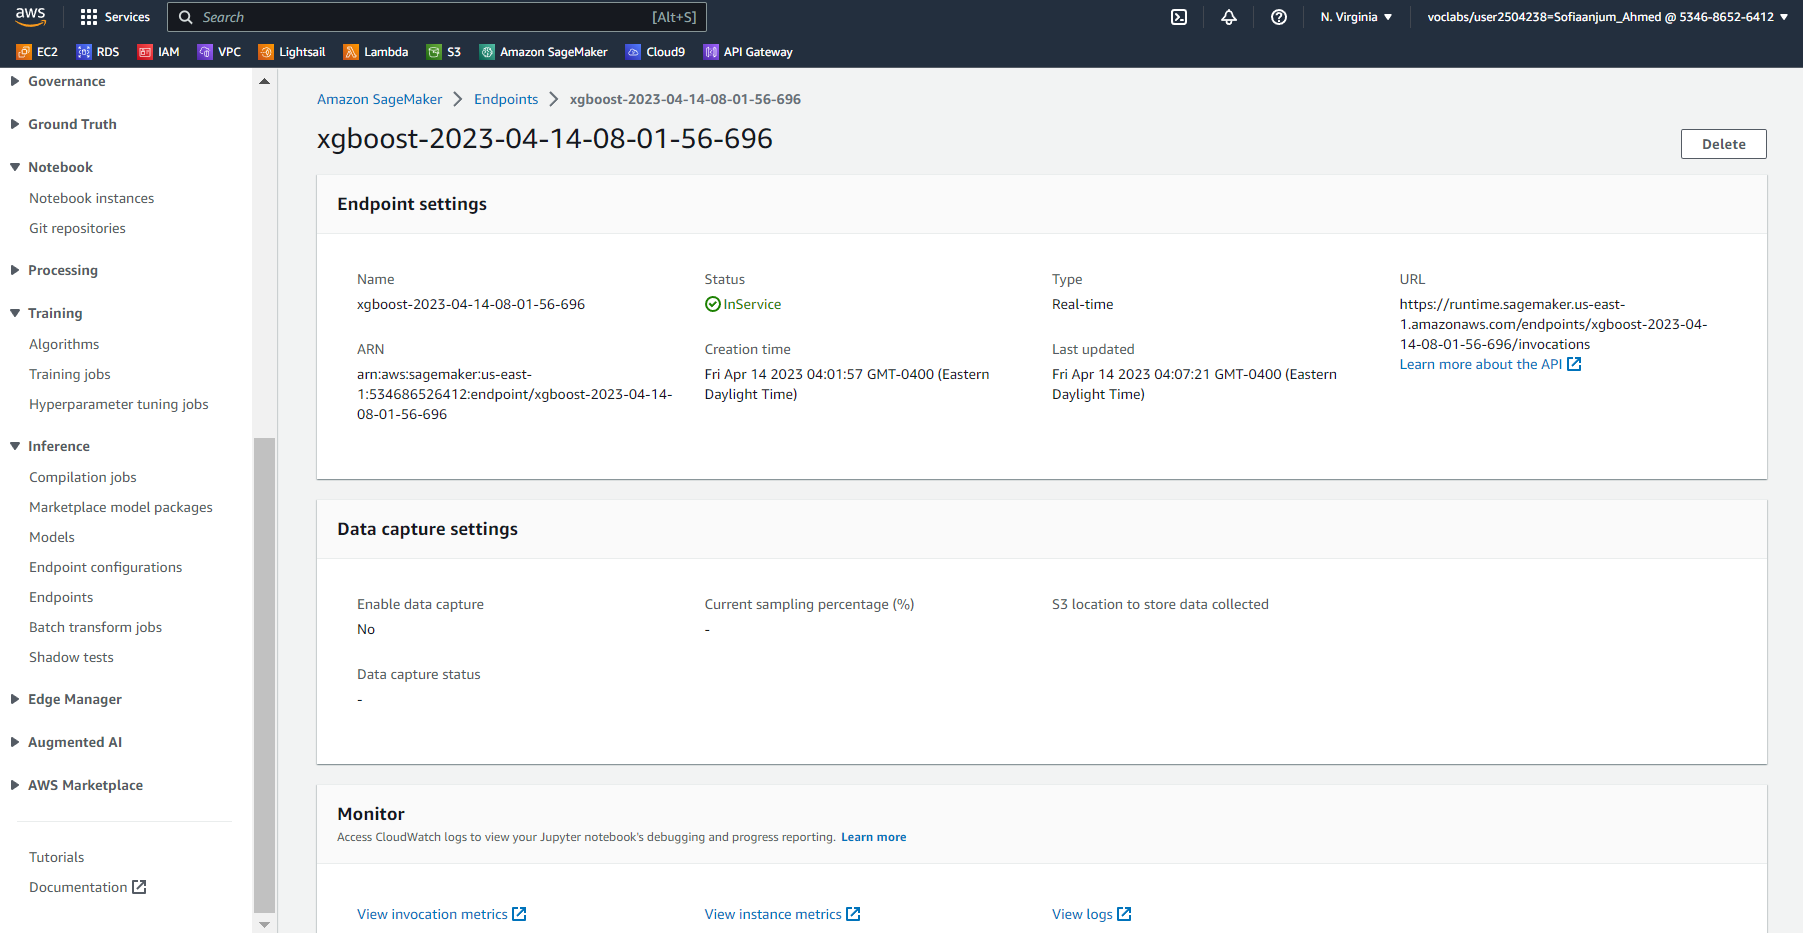

In [20]:
y_test = pd.read_csv('y_test.csv', header=None)
y_test.head()

,0
0,0
1,1
2,1
3,0
4,0


In [27]:
ground_truth_label, features = y_test, test_data

In [28]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       502 non-null    int64  
 1   1       502 non-null    int64  
 2   2       502 non-null    int64  
 3   3       502 non-null    int64  
 4   4       502 non-null    int64  
 5   5       502 non-null    float64
 6   6       502 non-null    int64  
 7   7       502 non-null    int64  
 8   8       502 non-null    int64  
 9   9       502 non-null    float64
dtypes: float64(2), int64(8)
memory usage: 39.3 KB


In [29]:
features_1 = features.values

In [15]:
test_data.to_csv('test_data_final.csv', index=False)

In [30]:
import numpy as np
predictions = xgb_predictor.predict(features_1)

In [31]:
values = predictions.decode().split(',')
# Convert the values to an ndarray of floats
pred_y = np.fromiter(values, dtype=float)

pred_val = []
for i in pred_y:
    if i > 0.5:
        pred_val.append(0)
    else:
        pred_val.append(0)

ground_truth_label = ground_truth_label.to_numpy()
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(ground_truth_label, pred_val)

In [32]:
accuracy

0.8047808764940239

In [33]:
xgb_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: xgboost-2023-04-14-08-01-56-696
INFO:sagemaker:Deleting endpoint with name: xgboost-2023-04-14-08-01-56-696


# Second Run

In [34]:
sess = sagemaker.Session()

container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, "latest")

xgb = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(eval_metric="auc", objective="binary:logistic", num_round=250,)


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [35]:
import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.inputs import TrainingInput

import numpy as np  # For matrix operations and numerical processing
import pandas as pd  # For munging tabular data
import os
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 10),
}

In [36]:
objective_metric_name = "validation:auc"

In [37]:
tuner = HyperparameterTuner(
    xgb, objective_metric_name, hyperparameter_ranges, max_jobs=5, max_parallel_jobs=5
)

In [38]:
tuner.fit({"train": s3_input_train, "validation": s3_input_validation}, include_cls_metadata=False)

INFO:sagemaker:Creating hyperparameter tuning job with name: xgboost-230414-0817


.......................................................!


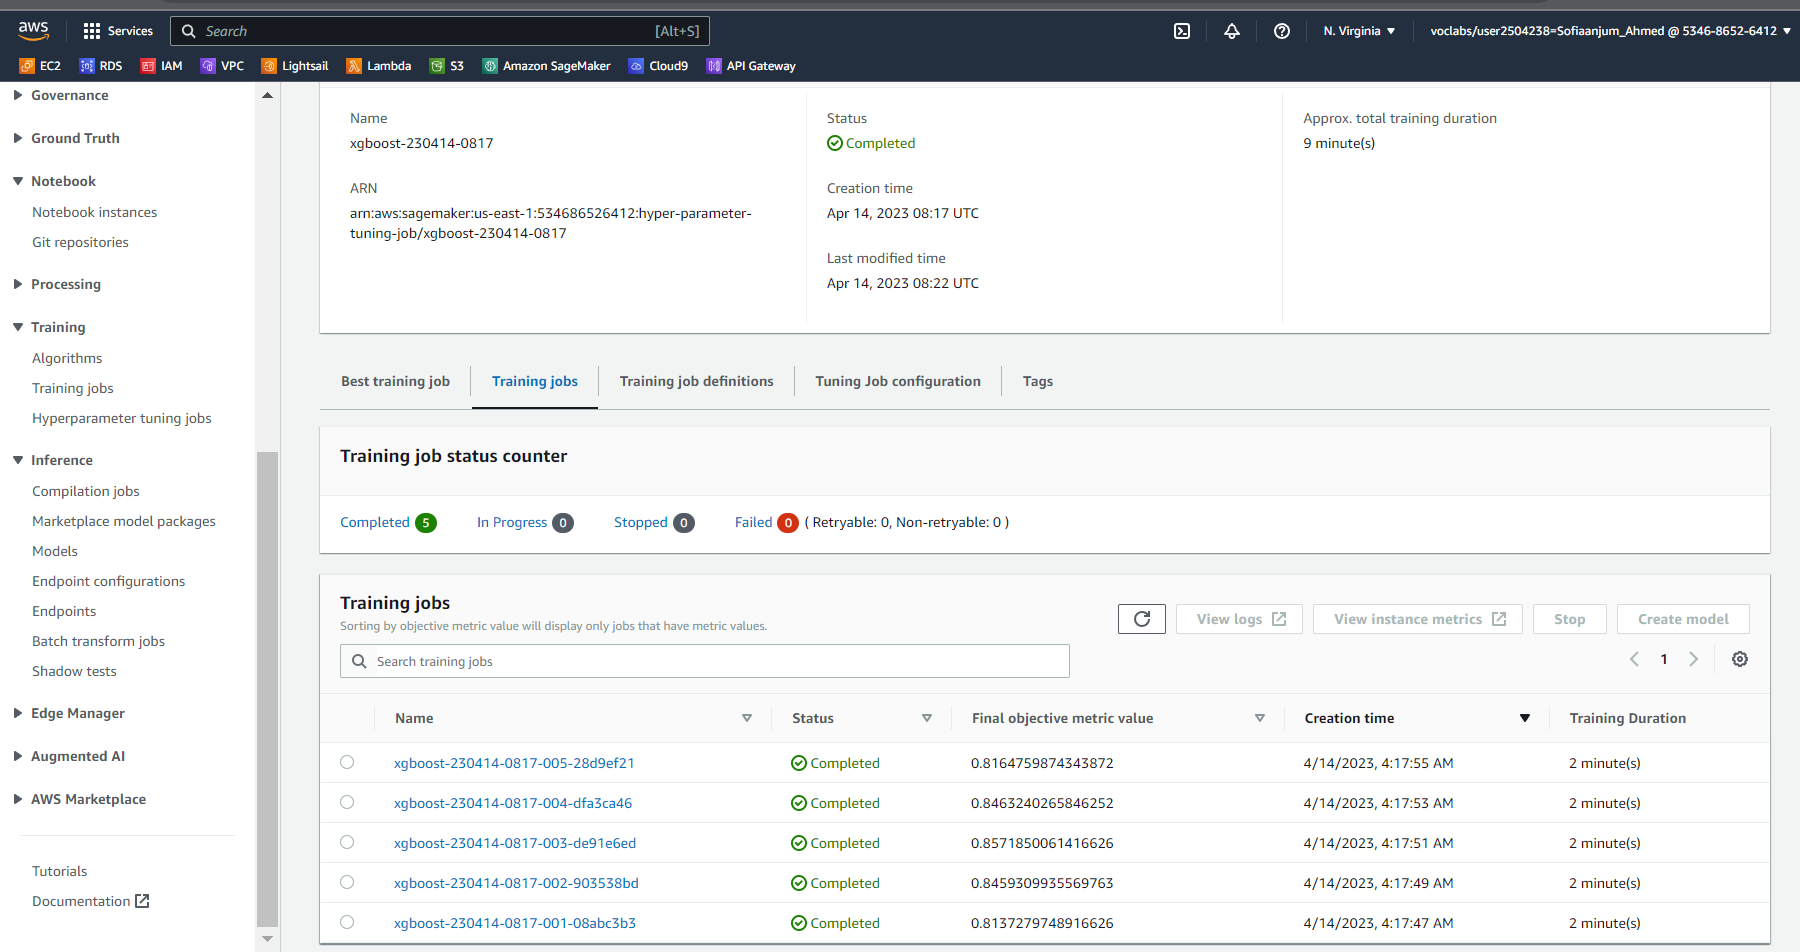

In [39]:
import boto3
import sagemaker
import os

region = boto3.Session().region_name
sage_client = boto3.Session().client("sagemaker")

tuning_job_name = "xgboost-230414-0817"

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [40]:
# run this cell to check current status of hyperparameter tuning job
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)

status = tuning_job_result["HyperParameterTuningJobStatus"]
if status != "Completed":
    print("Reminder: the tuning job has not been completed.")

job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" % job_count)

objective = tuning_job_result["HyperParameterTuningJobConfig"]["HyperParameterTuningJobObjective"]
is_minimize = objective["Type"] != "Maximize"
objective_name = objective["MetricName"]

5 training jobs have completed


In [41]:
from pprint import pprint

if tuning_job_result.get("BestTrainingJob", None):
    print("Best model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2023, 4, 14, 8, 17, 51, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:auc',
                                                 'Value': 0.8571850061416626},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2023, 4, 14, 8, 21, 9, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:534686526412:training-job/xgboost-230414-0817-003-de91e6ed',
 'TrainingJobName': 'xgboost-230414-0817-003-de91e6ed',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2023, 4, 14, 8, 19, 32, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '1.5911823440973365',
                          'eta': '0.06438128067351401',
                          'max_depth': '2',
                          'min_child_weight': '9.57057152357561'}}


In [42]:
xgb.set_hyperparameters(alpha= 1.5911823440973365,
                          eta= 0.06438128067351401,
                          max_depth= 2,
                          min_child_weight= 9.57057152357561,)
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

INFO:sagemaker:Creating training-job with name: xgboost-2023-04-14-08-24-38-444


2023-04-14 08:24:38 Starting - Starting the training job......
2023-04-14 08:25:09 Starting - Preparing the instances for training......
2023-04-14 08:26:19 Downloading - Downloading input data...
2023-04-14 08:26:49 Training - Downloading the training image...
2023-04-14 08:27:40 Training - Training image download completed. Training in progress...Arguments: train
[2023-04-14:08:27:49:INFO] Running standalone xgboost training.
[2023-04-14:08:27:49:INFO] File size need to be processed in the node: 0.34mb. Available memory size in the node: 8594.39mb
[2023-04-14:08:27:49:INFO] Determined delimiter of CSV input is ','
[08:27:49] S3DistributionType set as FullyReplicated
[08:27:49] 6499x10 matrix with 64990 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2023-04-14:08:27:49:INFO] Determined delimiter of CSV input is ','
[08:27:49] S3DistributionType set as FullyReplicated
[08:27:49] 2999x10 matrix with 29990 entries loaded from /opt/ml/input/data/valida

In [43]:
xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge', serializer = CSVSerializer())

INFO:sagemaker:Creating model with name: xgboost-2023-04-14-08-28-35-951
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-04-14-08-28-35-951
INFO:sagemaker:Creating endpoint with name xgboost-2023-04-14-08-28-35-951


--------!

### Model Creation

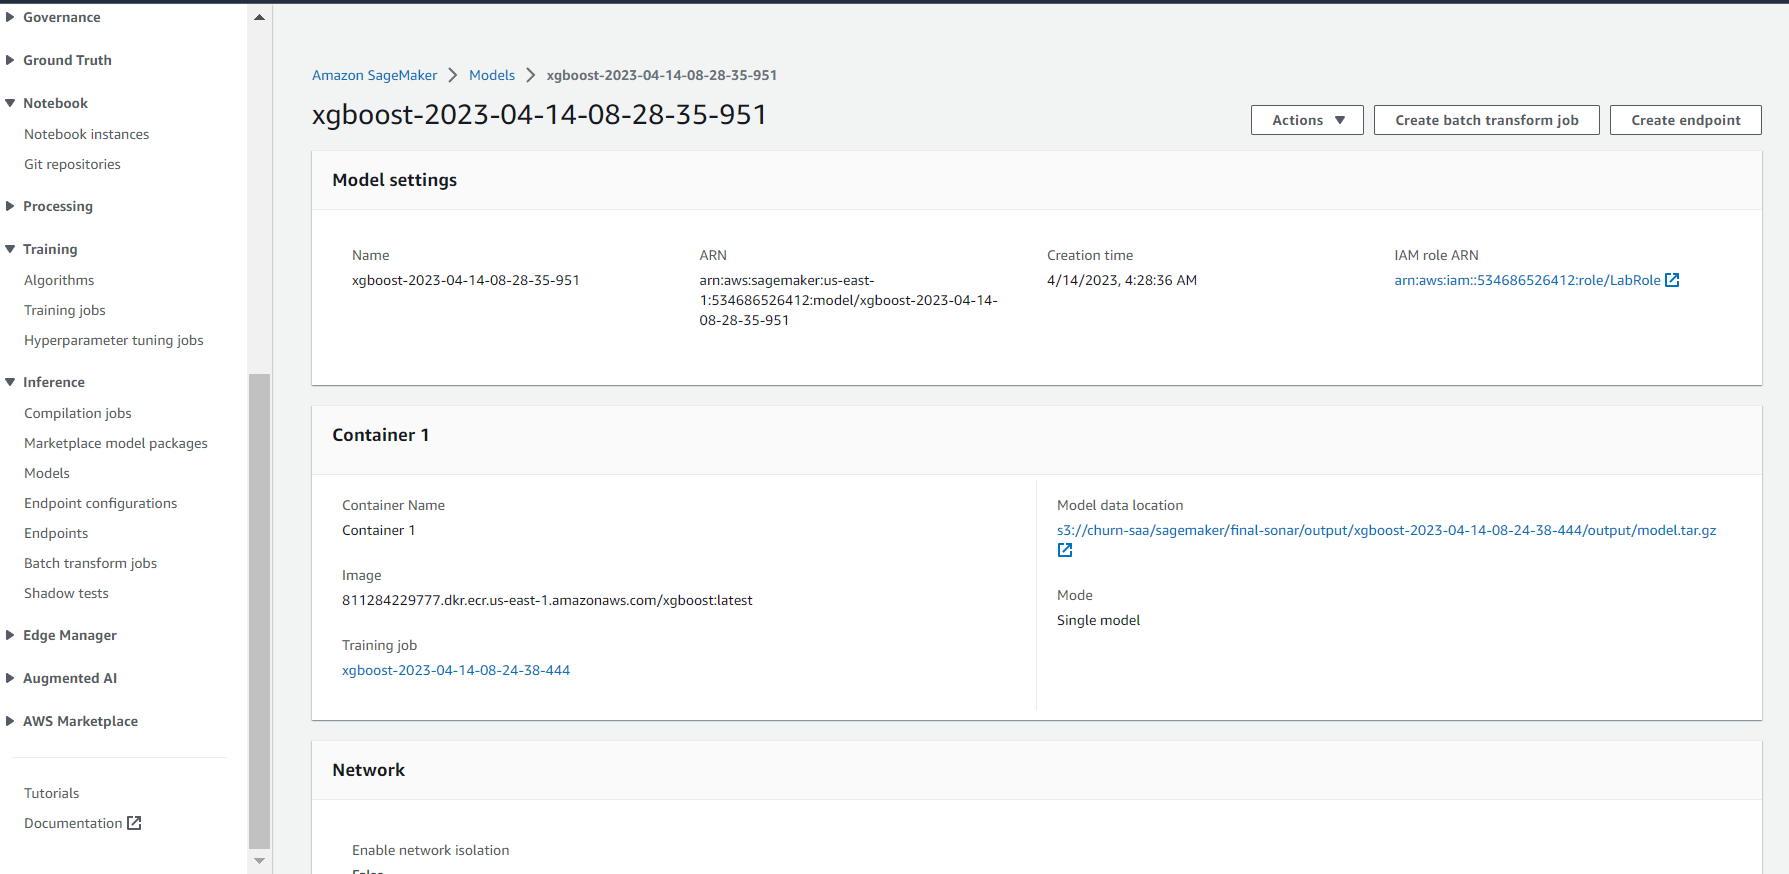

### Endpoint

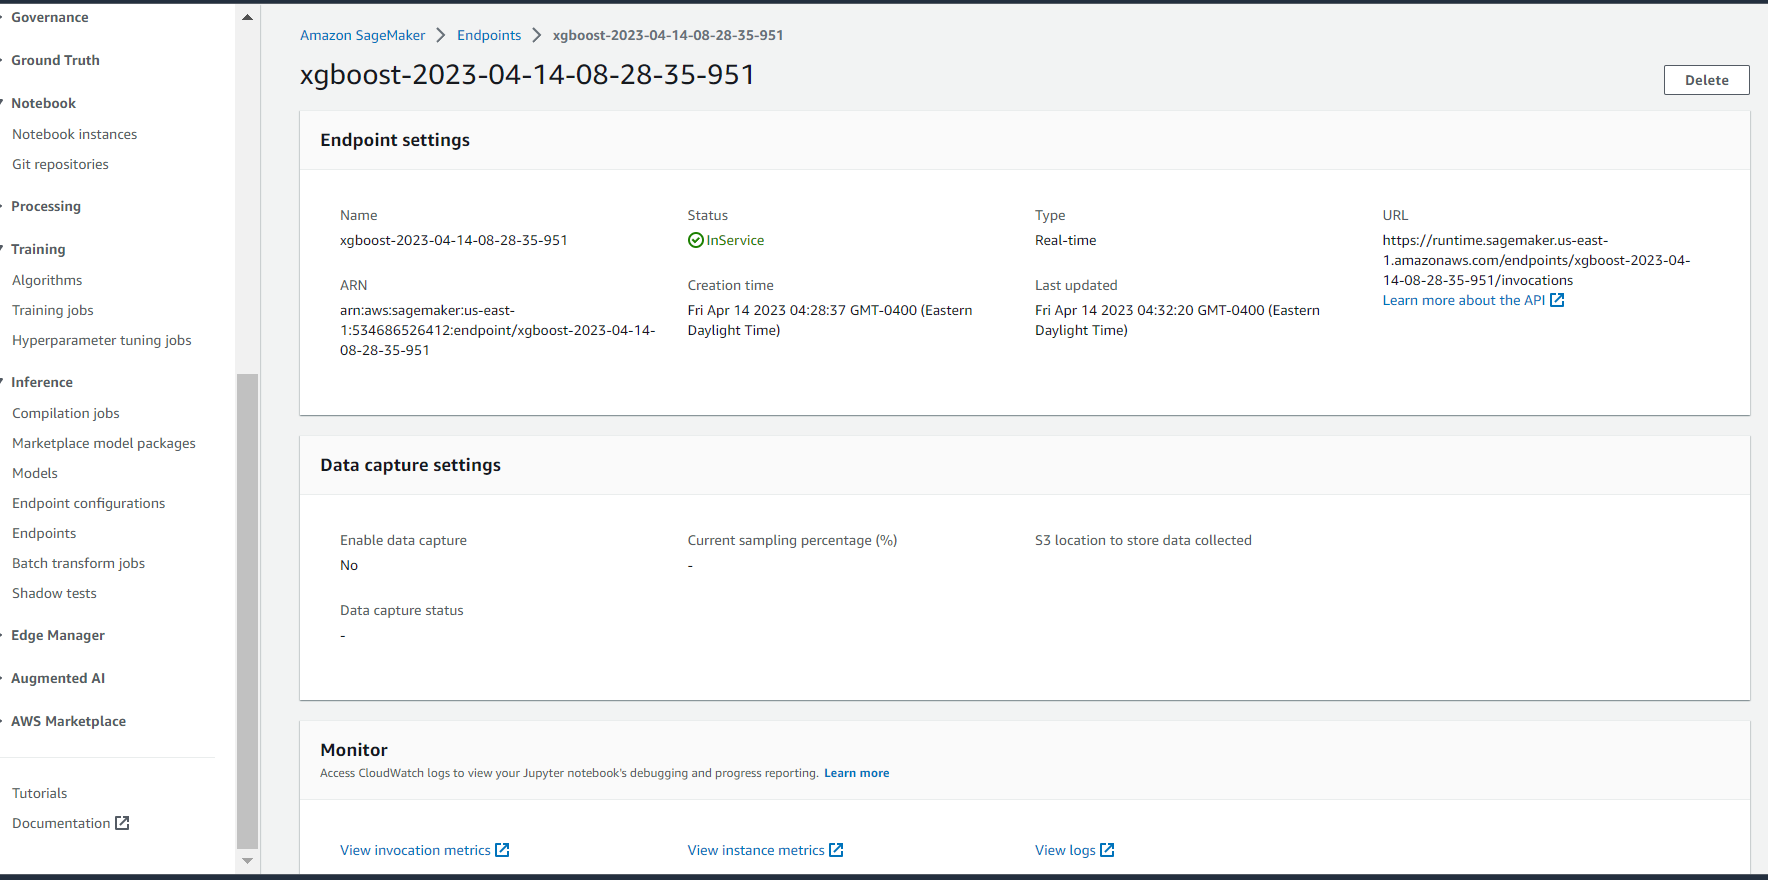

In [52]:
predictions = xgb_predictor.predict(features_1)
pred_y = np.fromiter(values, dtype=float)
pred_y

pred_val = []
for i in pred_y:
    if i > 0.5:
        pred_val.append(1)
    else:
        pred_val.append(0)

ground_truth_label = ground_truth_label.to_numpy()
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(ground_truth_label, pred_val)
accuracy

0.8705179282868526

In [64]:
xgb_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: xgboost-2023-04-14-04-48-55-612
INFO:sagemaker:Deleting endpoint with name: xgboost-2023-04-14-04-48-55-612
